In [1]:
library(ggplot2)
library(ggpubr)
library(readxl)
library(dplyr)
library(RColorBrewer)
library(reshape2)
library(phyloseq)
library(caret)
library("vsn")
library(vegan)
library(stringr)
library(UpSetR)
library(MicrobiomeStat)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to B

# Read phyloseq object

In [2]:
ps <- readRDS(file="/home/zeyang.shen/lab_data/PI/Vitality/RDS/bracken_results_ns38-46+56-57+62+66+94+96_Species_BasedOn_20220511_standard+SMGC+ELSGv2+ns66+T2T.Aug2025.t10.ps.rds")
ps <- subset_taxa(ps, Genus!="Homo")
sample_data.df <- sample_data(ps)
sample_data.df$total_abundance <- rowSums(otu_table(ps))
sample_data(ps) <- sample_data.df
ps <- subset_samples(ps, location!="novaseq6000")
ps <- subset_samples(ps, group!=".")
ps <- subset_samples(ps, !(site_specific %in% c("Ctrl", "PrepCtrl", "(empty)", "N", "ZymoD6306")))
ps <- tax_glom(ps, taxrank="Species", NArm=FALSE)

[1] "Total samples: 1078"
[1] "Samples selected: 1072"
[1] "After filter on reads: 1068"
[1] "Subsampling to reads: 119027"


`set.seed(10)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(10); .Random.seed` for the full vector

...

1246OTUs were removed because they are no longer 
present in any sample after random subsampling


...



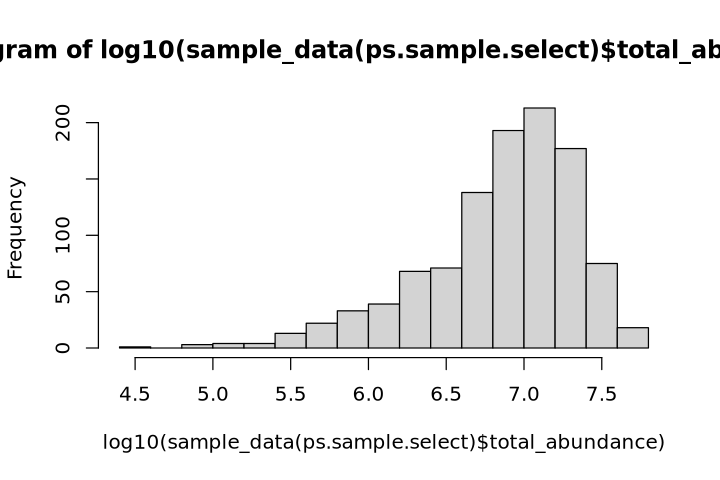

In [3]:
exclude_samples <- c("Met4959", "Met4960", #air control and Ac:T3 likely swapped
                     "Met5191", "Met5192", #control has more reads than samples
                     "Met4929", #similar number of reads as air control
                     "Met5528" #only 8700 total reads
                    )

#1.Select samples
print(paste("Total samples:", nsamples(ps)))
ps.sample.select <- subset_samples(ps, !(Sample %in% exclude_samples))
print(paste("Samples selected:", nsamples(ps.sample.select)))
options(repr.plot.width = 6, repr.plot.height = 4)
hist(log10(sample_data(ps.sample.select)$total_abundance))

##filter sample by total reads
ps.sample.select2 <- subset_samples(ps.sample.select, total_abundance > 100000)
print(paste("After filter on reads:", nsamples(ps.sample.select2)))

##rarefication
print(paste("Subsampling to reads:", min(rowSums(otu_table(ps.sample.select2)))))
ps.rarefy <- rarefy_even_depth(ps.sample.select2, rngseed=10)

# Fig 3a

In [4]:
tax.tb <- as.data.frame(tax_table(ps.sample.select2))
cov.file <- "/home/zeyang.shen/lab_data/personal/Zeyang/Vitality/RefSeq+ELSG+SMGC.default.coverm.tsv"
cov.df <- read.csv(cov.file, sep="\t")
cov.df$Species <- unlist(lapply(cov.df[,1], function(x) {paste(unlist(str_split(x, " "))[1:2], collapse=" ")}))
cov.lst <- c()
for (s in tax.tb$Species){
    if (s %in% cov.df$Species){
        cov.lst <- c(cov.lst, max(cov.df[cov.df$Species==s,"X0.99"]))
    } else {
        cov.lst <- c(cov.lst, NaN)
    }
}
tax.tb$Coverage <- cov.lst

In [5]:
run_linda_on_phyloseq <- function(ps.deseq, 
                                  comparison_label = NULL, 
                                  n.cores = 16) {
  # Build feature table (relative abundance)
  feature.table <- data.frame(t(otu_table(ps.deseq)))
  rel_abund <- sweep(feature.table, 2, colSums(feature.table), FUN = "/")
  
  # Metadata
  meta.table <- data.frame(sample_data(ps.deseq))
  
  # Try LinDA
  tryCatch({
    linda.obj <- linda(
      rel_abund,
      meta.table,
      formula = "~group",
      feature.dat.type = "proportion",
      is.winsor = TRUE,
      prev.filter = 0.3,
      mean.abund.filter = 1e-5,
      p.adj.method = "BH",
      n.cores = n.cores
    )
    
    linda_output <- linda.obj$output[[1]]
    linda.res <- linda_output[, c("log2FoldChange", "padj")]
    colnames(linda.res) <- c("log2FC", "qval")
    linda.res$taxID <- rownames(linda.res)
    linda.res$method <- "LinDA"
    
    # Add taxonomic annotations if available
    display.df <- data.frame(linda.res, tax_table(ps.deseq)[linda.res$taxID,])
    if (!is.null(comparison_label)) {
      display.df$comparison <- comparison_label
    }
    
    # Add abundance and prevalence metrics
    display.df$abundance.median <- apply(otu_table(ps.deseq) / rowSums(otu_table(ps.deseq)), 2, median)[display.df$taxID]
    display.df$abundance.max <- apply(otu_table(ps.deseq) / rowSums(otu_table(ps.deseq)), 2, max)[display.df$taxID]
    display.df$prevalence <- apply(otu_table(ps.deseq), 2, function(x) sum(x > 0) / length(x))[display.df$taxID]
    display.df$coverage <- tax.tb[display.df$taxID, "Coverage"]    
    return(display.df)
    
  }, error = function(e) {
    message("LinDA failed: ", e$message)
    return(NULL)
  })
}

In [6]:
# Disease vs HC
comp1 <- c("1", "2", "3")
comp2 <- c("4", "4", "4")
DA.res <- c()

ps.subset <- subset_samples(ps.sample.select2, babymom_site_visit=="B:Ac:T1")
for (g in seq_len(length(comp1))){
    # AD, AD+FA, AD+FS
    ps.deseq <- subset_samples(ps.subset, (group==comp1[g]&any_eczema_ever_d=="yes"&eczema_dr_skin_T1_d!=".")|(group==comp2[g]))
    print(table(sample_data(ps.deseq)$group3, sample_data(ps.deseq)$eczema_dr_skin_T1_d))
    cur.res <- run_linda_on_phyloseq(ps.deseq, paste0("Group",comp1[g],"_AcvsGroup",comp2[g]))
    DA.res <- rbind(DA.res, cur.res)
    flush.console()
    
    # # FA or FS only
    # ps.deseq <- subset_samples(ps.subset, (group==comp1[g]&any_eczema_ever_d=="no")|(group==comp2[g]))
    # print(table(sample_data(ps.deseq)$group3, sample_data(ps.deseq)$any_eczema_ever_d))
    # cur.res <- run_linda_on_phyloseq(ps.deseq, paste0("Group",comp1[g],"only_AcvsGroup",comp2[g]))
    # DA.res <- rbind(DA.res, cur.res)
    # flush.console()
}

ps.deseq <- subset_samples(ps.subset, (any_eczema_ever_d=="yes"&eczema_dr_skin_T1_d!=".")|(group=="4"))
print(table(sample_data(ps.deseq)$group3, sample_data(ps.deseq)$eczema_dr_skin_T1_d))
cur.res <- run_linda_on_phyloseq(ps.deseq, paste0("AD_AcvsHC"))
DA.res <- rbind(DA.res, cur.res)
flush.console()

ps.subset <- subset_samples(ps.sample.select2, babymom_site_visit=="B:Ch:T1")
for (g in seq_len(length(comp1))){
    # AD, AD+FA, AD+FS
    ps.deseq <- subset_samples(ps.subset, (group==comp1[g]&any_eczema_ever_d=="yes"&eczema_dr_skin_T1_d!=".")|(group==comp2[g]))
    print(table(sample_data(ps.deseq)$group3, sample_data(ps.deseq)$eczema_dr_skin_T1_d))
    cur.res <- run_linda_on_phyloseq(ps.deseq, paste0("Group",comp1[g],"_ChvsGroup",comp2[g]))
    DA.res <- rbind(DA.res, cur.res)
    flush.console()
    
    # # FA or FS only
    # ps.deseq <- subset_samples(ps.subset, (group==comp1[g]&any_eczema_ever_d=="no")|(group==comp2[g]))
    # print(table(sample_data(ps.deseq)$group3, sample_data(ps.deseq)$any_eczema_ever_d))
    # cur.res <- run_linda_on_phyloseq(ps.deseq, paste0("Group",comp1[g],"only_ChvsGroup",comp2[g]))
    # DA.res <- rbind(DA.res, cur.res)
    # flush.console()
}

ps.deseq <- subset_samples(ps.subset, (any_eczema_ever_d=="yes"&eczema_dr_skin_T1_d!=".")|(group=="4"))
print(table(sample_data(ps.deseq)$group3, sample_data(ps.deseq)$eczema_dr_skin_T1_d))
cur.res <- run_linda_on_phyloseq(ps.deseq, paste0("AD_ChvsHC"))
DA.res <- rbind(DA.res, cur.res)
flush.console()

           
            no
  1_yes_.    1
  1_yes_no   6
  1_yes_yes  3
  4_no_no   28
8276  features are filtered!
The filtered data has  38  samples and  1236  features will be tested!
Fit linear models ...
Completed.
          
           no
  2_yes_.   1
  2_yes_no  4
  4_no_no  28
8300  features are filtered!
The filtered data has  33  samples and  1212  features will be tested!
Fit linear models ...
Completed.
           
            no
  3_yes_.    2
  3_yes_no  19
  3_yes_yes  8
  4_no_no   28
8163  features are filtered!
The filtered data has  57  samples and  1349  features will be tested!
Fit linear models ...
Completed.
           
            no
  1_yes_.    1
  1_yes_no   6
  1_yes_yes  3
  2_yes_.    1
  2_yes_no   4
  3_yes_.    2
  3_yes_no  19
  3_yes_yes  8
  4_no_no   28
8166  features are filtered!
The filtered data has  72  samples and  1346  features will be tested!
Fit linear models ...
Completed.
           
            no
  1_yes_.    1
  1_yes_no   7
  1_yes_

In [7]:
abund.cutoff <- 0
fc.cutoff <- 0
q.cutoff <- 0.1
cov.cutoff <- 0.6
DA.res$log10q <- -log10(DA.res$qval)
DA.res$method_comparison <- paste0(DA.res$comparison, "_", DA.res$method)
DA.res <- DA.res[order(DA.res$qval),]

all.sig.taxa <- c()
for (comp in unique(DA.res$comparison)){
    print(comp)
    pos.sig.taxa1 <- subset(DA.res, comparison==comp & log2FC > fc.cutoff & abundance.median > abund.cutoff & (coverage > cov.cutoff | Genus=='Malassezia'))$taxID
    if (length(pos.sig.taxa1)>0){
        pos.mtx <- dcast(subset(DA.res, comparison==comp & taxID %in% pos.sig.taxa1), taxID+comparison~method, value.var = "qval", fill = 1)
        pos.sig.taxa2 <- subset(pos.mtx, (LinDA < q.cutoff))$taxID
        print(paste("Increased:", length(pos.sig.taxa2)))
        if (length(pos.sig.taxa2) > 0){print(tax.tb[pos.sig.taxa2,c("Species", "Coverage")])}
        all.sig.taxa <- c(all.sig.taxa, pos.sig.taxa2)
    }
    
    neg.sig.taxa1 <- subset(DA.res, comparison==comp & log2FC < -fc.cutoff & abundance.median > abund.cutoff & (coverage > cov.cutoff | Genus=='Malassezia'))$taxID
    if (length(neg.sig.taxa1)>0){
        neg.mtx <- dcast(subset(DA.res, comparison==comp & taxID %in% neg.sig.taxa1), taxID+comparison~method, value.var = "qval", fill = 1)
        neg.sig.taxa2 <- subset(neg.mtx, (LinDA < q.cutoff))$taxID
        print(paste("Decreased:", length(neg.sig.taxa2)))
        if (length(neg.sig.taxa2) > 0){print(tax.tb[neg.sig.taxa2,c("Species", "Coverage")])}
        all.sig.taxa <- c(all.sig.taxa, neg.sig.taxa2)
    }
}
DA.sig.res <- subset(DA.res, taxID %in% all.sig.taxa)
length(all.sig.taxa)

[1] "Group2_AcvsGroup4"
[1] "Increased: 0"
[1] "Decreased: 1"
                           Species Coverage
29385 Staphylococcus saprophyticus 0.866178
[1] "Group1_AcvsGroup4"
[1] "Increased: 0"
[1] "Decreased: 5"
                                Species  Coverage
1260                   Finegoldia magna 0.6859193
1280              Staphylococcus aureus 0.7912829
1979527 Corynebacterium kefirresidentii 0.9439095
2702              Gardnerella vaginalis 0.7470949
80878              Acidovorax temperans 0.6280353
[1] "Group1_ChvsGroup4"
[1] "Increased: 0"
[1] "Decreased: 4"
                                Species  Coverage
1260                   Finegoldia magna 0.6859193
1280              Staphylococcus aureus 0.7912829
1979527 Corynebacterium kefirresidentii 0.9439095
29388            Staphylococcus capitis 0.9116286
[1] "AD_ChvsHC"
[1] "Increased: 0"
[1] "Decreased: 0"
[1] "AD_AcvsHC"
[1] "Increased: 0"
[1] "Decreased: 0"
[1] "Group2_ChvsGroup4"
[1] "Increased: 0"
[1] "Decreased: 0"
[1] "G

[1] 10

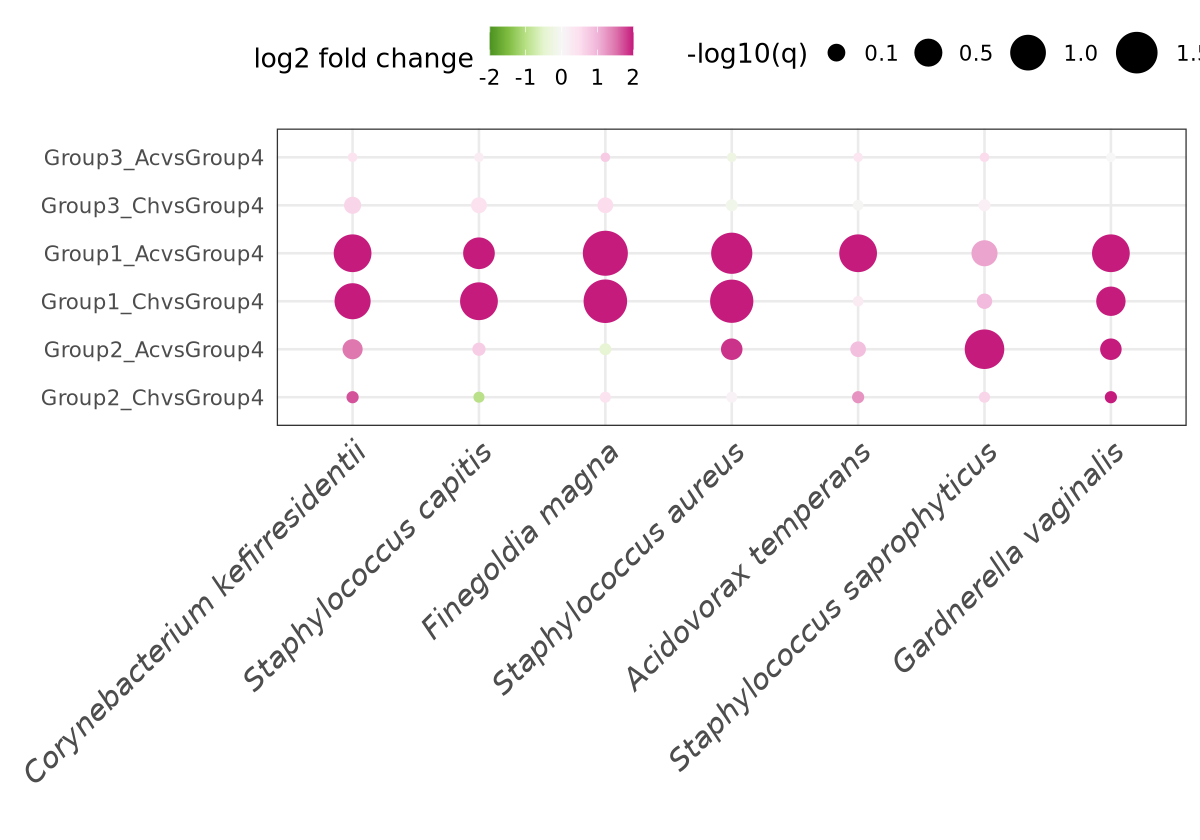

In [8]:
select.groups <- c("Group2_ChvsGroup4","Group2_AcvsGroup4",
                   "Group1_ChvsGroup4","Group1_AcvsGroup4",
                   "Group3_ChvsGroup4","Group3_AcvsGroup4")
DA.sig.res <- subset(DA.sig.res, comparison %in% select.groups)
DA.sig.res$comparison <- factor(DA.sig.res$comparison, level=select.groups)

colors <- colorRampPalette(rev(brewer.pal(9, "PiYG")))(255)
options(repr.plot.width = 10, repr.plot.height = 7)
dp1 <- ggplot(DA.sig.res, aes(x=reorder(Species, -abundance.median), y=comparison, color = -log2FC, size = log10q)) + 
    geom_point()+
    scale_color_gradientn(colours = colors, limits = c(-2,2), oob = scales::squish, name = 'log2 fold change')+
    scale_size_continuous(range=c(2,12), breaks=c(0.1,0.5,1,1.5), name='-log10(q)')+
    labs(x="", y="")+
    theme_bw(base_size=16)+
    theme(axis.text.x = element_text(size=18, angle = 45, vjust = 1, hjust=1, face="italic"), 
          legend.position='top')+
    theme(axis.ticks = element_blank())
dp1
ggsave(dp1, width=10, height=7, file="../figs/AD_DA_T1.eps", device="eps")

# Fig 3b

In [4]:
ps.subset2 <- subset_samples(ps.sample.select2, visit=="T1" & babymom=="B")
select_melt <- psmelt(ps.subset2)

Warning message in psmelt(ps.subset2):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”


In [5]:
substr <- "Staphylococcus aureus" #Staphylococcus aureus/saprophyticus/capitis, Corynebacterium kefirresidentii
display_set <- subset(select_melt, grepl(substr, Species))
unique(display_set$OTU)
select.group2 <- c("3_yes", "1_yes", "2_yes", "1_no", "2_no", "4_no")
display_set <- subset(display_set, group2 %in% select.group2)
display_set$group2 <- factor(display_set$group2, level=select.group2)
display_set$Relative.Abundance <- (display_set$Abundance/display_set$total_abundance)*100

[1] "1280"

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


,babymom_site_visit,.y.,group1,group2,p,p.adj,p.format,p.signif,method
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
5,B:Ac:T1,Relative.Abundance,3_yes,4_no,0.9305953621,0.900,0.93060,ns,Wilcoxon
9,B:Ac:T1,Relative.Abundance,1_yes,4_no,0.0020361863,0.010,0.00204,**,Wilcoxon
12,B:Ac:T1,Relative.Abundance,2_yes,4_no,0.1286277682,0.400,0.12863,ns,Wilcoxon
14,B:Ac:T1,Relative.Abundance,1_no,4_no,0.4481747396,0.700,0.44817,ns,Wilcoxon
15,B:Ac:T1,Relative.Abundance,2_no,4_no,0.1931034483,0.400,0.19310,ns,Wilcoxon
20,B:Ch:T1,Relative.Abundance,3_yes,4_no,0.9158565748,0.900,0.91586,ns,Wilcoxon
24,B:Ch:T1,Relative.Abundance,1_yes,4_no,0.0003459431,0.003,0.00035,***,Wilcoxon
27,B:Ch:T1,Relative.Abundance,2_yes,4_no,0.5416203189,0.800,0.54162,ns,Wilcoxon
29,B:Ch:T1,Relative.Abundance,1_no,4_no,0.1570178987,0.400,0.15702,ns,Wilcoxon


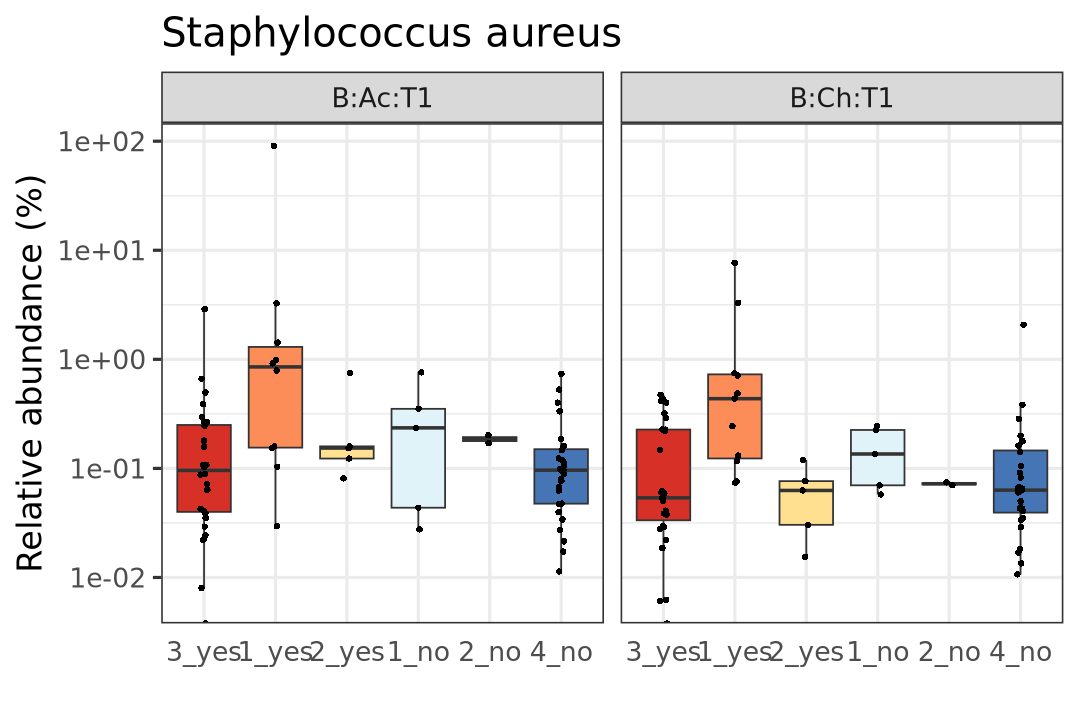

In [6]:
options(repr.plot.width = 9, repr.plot.height = 6)
my_cols <- brewer.pal(6, "RdYlBu")[1:6]
p1 <- ggplot(display_set, aes(
    x=group2, y=Relative.Abundance, fill=group2)) + 
    geom_boxplot(outlier.shape = NA) + 
    geom_jitter(shape=16, position=position_jitter(0.05)) +
    labs(y="Relative abundance (%)", x="", title=substr) +
    scale_y_log10() +
    facet_grid(~babymom_site_visit, scales="free", space="free") +
    theme_bw(base_size=20) +
    scale_fill_manual(values = my_cols) +
    theme(axis.text.x = element_text(angle=0, vjust=0.5), axis.ticks.x=element_blank(), legend.position = "none")
p1
# ggsave(p1, width=9, height=6, file=paste0("~/figs/AD_abundance_T1_", str_replace(substr, " ", "_"), ".eps"), device="eps")

pvals <- compare_means(
  Relative.Abundance ~ group2,
  data = display_set,
  method = "wilcox.test",
  p.adjust.method = "BH",
    group.by = "babymom_site_visit"
)
pvals <- as.data.frame(pvals)
pvals <- subset(pvals, group2=="4_no")
pvals$p.adj <- signif(p.adjust(pvals$p, method = "BH"),1)
pvals